In [45]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

In [3]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    

    #Radius
    R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year
    M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

## This assumes you have made a dense grid at the time you are interested in already.

## PS1-11aop

In [33]:
#Read in file that has the sets of parameters you want to check.
#Use to make a list of velocities and Mdots

file_in = 'PS11aop_grid_e2_allowed.csv'
datap = ascii.read(file_in)

index = np.where(datap['RuledOut'] == 'False')[0]
v_shock_l = datap['v_shock'][index]
Mdot_l = datap['Mdot'][index]

#Read in the dense grid for the time you want.
t = 2980
D = 1070.14 
file_in2 = 'SSAgrid_11aop_d'+np.str(t)+'.csv'
data=ascii.read(file_in2)
file_out = 'Projection_11aop_SSA_d'+np.str(t)+'.csv'

#Define parameters to be saved: 
Fp_best = []
nu_p_best = []
R_best = []
vsh_best = []
M_best = []

#Cycle over the lists of Mdot and velocity to find fp and nu_p at this time

for i in range(len(Mdot_l)):
    Mdot = Mdot_l[i]
    velocity = v_shock_l[i]
    
    #Figure out what radius it will be at this time:
    radius = velocity*1e5*t*86400.
    
    #Somehow interpolate the grid to our best fit? Prioritize Mdot? Then radius?
    #(1) Find all Mdot within a certain tolerance
    toleranceM = Mdot *0.01 #allow a 1% difference.
    maxiM = Mdot+toleranceM
    miniM = Mdot-toleranceM

    index = np.where((data['Mdot'] < maxiM))[0]
    data2=data[index]
    index2 = np.where(data2['Mdot'] > miniM)[0]
    data3=data2[index2]

    toleranceR = radius*0.01
    maxiR = radius+toleranceR
    miniR = radius-toleranceR
    index3 = np.where(data3['Radius'] < maxiR)[0]
    data4=data3[index3]
    index4 = np.where(data4['Radius'] > miniR)[0]
    data5=data4[index4]
    print('time',t,'numbers',len(index),len(index2),len(index3),len(index4))
    
    #Run a mini-grid in the region probed by the within 1% case. 
    
    F_p_2 = np.linspace(np.min(data5['F_peak']),np.max(data5['F_peak']),num=50) 
    nu_p_2 = np.linspace(np.min(data5['nu_peak']),np.max(data5['nu_peak']),num=50) 
    
    Fp_g2 = [] #peak flux
    nup_g2 =[] #peak frequency
    R_g2 =[] #radius
    vsh_g2 = [] #velocity of shock
    M_g2 = [] #mass loss rate
    
    for F in F_p_2:
        for nu in nu_p_2:
        
            #calculate Mass loss rate, Radius, velocity, etc.
            R,B,E,v,M = SSA_props(t,nu,F,D)
        
            # Append the values from this loop into the arrays that we defined above:
            Fp_g2.append(F) 
            nup_g2.append(nu) 
            R_g2.append(R) 
            vsh_g2.append(v) 
            M_g2.append(M)
    
    #Somehow figure out which in this grid is closest. 
    frac_diff_R = np.abs((radius - np.array(R_g2))/radius)
    frac_diff_M = np.abs((Mdot - np.array(M_g2))/Mdot)
    frac_diff = np.sqrt(frac_diff_R**2+frac_diff_M**2)
    
    indexN = np.where(frac_diff == np.min(frac_diff))[0]
    print('time',t,'differentials',frac_diff_R[indexN],frac_diff_M[indexN],frac_diff[indexN])
    
    
    Fp_best.append(np.array(Fp_g2)[indexN][0])
    nu_p_best.append(np.array(nup_g2)[indexN][0])
    R_best.append(np.array(R_g2)[indexN][0])
    vsh_best.append(np.array(vsh_g2)[indexN][0])
    M_best.append(np.array(M_g2)[indexN][0])


Fp_best = np.array(Fp_best)
nu_p_best = np.array(nu_p_best)
R_best = np.array(R_best)
vsh_best = np.array(vsh_best)
M_best = np.array(M_best)
# Write out the results into a data file that you can use later:
data = [Fp_best,nu_p_best,R_best,vsh_best,M_best]
names = ['F_peak','nu_peak','Radius','v_shock','Mdot']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')




time 2980 numbers 192731 919 416 10
time 2980 differentials [ 0.00038885] [ 0.00014937] [ 0.00041655]
time 2980 numbers 178403 921 436 10
time 2980 differentials [ 0.00026692] [  3.34042662e-05] [ 0.000269]
time 2980 numbers 184884 919 437 10
time 2980 differentials [ 0.00012008] [ 0.00035362] [ 0.00037345]
time 2980 numbers 191367 920 437 12
time 2980 differentials [ 0.0003782] [ 0.00014464] [ 0.00040491]
time 2980 numbers 197849 920 438 10
time 2980 differentials [ 0.00019941] [ 0.00015626] [ 0.00025334]
time 2980 numbers 204331 920 437 10
time 2980 differentials [ 0.00018756] [ 0.00023072] [ 0.00029734]
time 2980 numbers 177038 921 457 10
time 2980 differentials [ 0.00023974] [ 0.00013586] [ 0.00027556]
time 2980 numbers 183519 919 455 10
time 2980 differentials [  4.07372519e-05] [ 0.00014464] [ 0.00015027]
time 2980 numbers 190002 919 455 10
time 2980 differentials [ 0.00034617] [ 0.00024234] [ 0.00042257]
time 2980 numbers 175672 919 474 10
time 2980 differentials [ 0.00016119] [

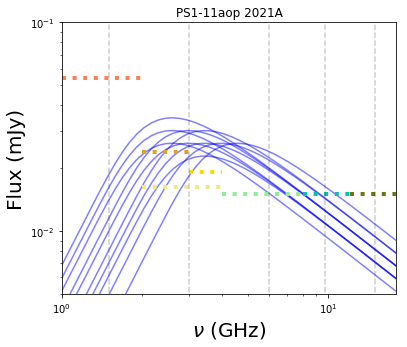

In [57]:
# Make a plot of the results for PS1-11aop:

t_p = 2980
D = 1070.14 

file_in = 'Projection_11aop_SSA_d2980.csv'
data_plot = ascii.read(file_in)

Fcalc = data_plot['F_peak']
nucalc = data_plot['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

#########################
#Set up the plot:
#########################
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(6,5))
plt.autoscale()
plt.xscale('log')
plt.yscale('log')


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)
    
#Overplot line for detection threshold:
plt.plot([1,2],[0.054, 0.054],linestyle=':',linewidth=4,color='coral')
#plt.plot([2,4],[0.018, 0.018],linestyle=':',linewidth=4)
#plt.plot([2,3],[0.027, 0.027],linestyle=':',linewidth=4)
#plt.plot([3,4],[0.0213, 0.0213],linestyle=':',linewidth=4)
plt.plot([2,4],[0.0162, 0.0162],linestyle=':',linewidth=4,color='khaki')
plt.plot([2,3],[0.024, 0.024],linestyle=':',linewidth=4,color='goldenrod')
plt.plot([3,4],[0.0192, 0.0192],linestyle=':',linewidth=4,color='gold')
plt.plot([4,8],[0.015, 0.015],linestyle=':',linewidth=4,color='lightgreen')
plt.plot([8,12],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:turquoise')
plt.plot([12,18],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:olive')


#Overplot central wavelengths for various bands:
plt.plot([15,15],[1e-3,1],'k--',alpha=0.2)
plt.plot([9.7,9.7],[1e-3,1],'k--',alpha=0.2)
plt.plot([6.0,6.0],[1e-3,1],'k--',alpha=0.2)
plt.plot([3.0,3.0],[1e-3,1],'k--',alpha=0.2)
plt.plot([1.5,1.5],[1e-3,1],'k--',alpha=0.2)

plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) 
plt.savefig('multiPS11aop.pdf')
plt.title('PS1-11aop 2021A')   
plt.ylim(5e-3,1e-1)
plt.xlim(1,18)

#Patch in the background:
#r1 = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.3,zorder=1)
#plt.add_patch(r1)

plt.show()


## PS1-11vo

In [35]:
#Read in file that has the sets of parameters you want to check.
#Use to make a list of velocities and Mdots

file_in = 'PS11vo_grid_e1_allowed.csv'
data_plot = ascii.read(file_in)

index = np.where(data_plot['RuledOut'] == 'False')[0]
data_plot2 = data_plot[index]
index2 = np.where(data_plot2['v_shock'] < 20000.)[0]
data_plot3 = data_plot2[index2]
index3 = np.where(data_plot3['v_shock'] > 2000.)[0]
data_plot4 = data_plot3[index3]

v_shock_l = data_plot4['v_shock']
Mdot_l = data_plot4['Mdot']

#Read in the dense grid for the time you want.
t = 3311
D = 543.4
file_in2 = 'SSAgrid_11vo_d'+np.str(t)+'.csv'
data=ascii.read(file_in2)
file_out = 'Projection_11vo_SSA_d'+np.str(t)+'.csv'

#Define parameters to be saved: 
Fp_best = []
nu_p_best = []
R_best = []
vsh_best = []
M_best = []

#Cycle over the lists of Mdot and velocity to find fp and nu_p at this time

for i in range(len(Mdot_l)):
    Mdot = Mdot_l[i]
    velocity = v_shock_l[i]
    
    #Figure out what radius it will be at this time:
    radius = velocity*1e5*t*86400.
    
    #Somehow interpolate the grid to our best fit? Prioritize Mdot? Then radius?
    #(1) Find all Mdot within a certain tolerance
    toleranceM = Mdot *0.01 #allow a 1% difference.
    maxiM = Mdot+toleranceM
    miniM = Mdot-toleranceM

    index = np.where((data['Mdot'] < maxiM))[0]
    data2=data[index]
    index2 = np.where(data2['Mdot'] > miniM)[0]
    data3=data2[index2]

    toleranceR = radius*0.01
    maxiR = radius+toleranceR
    miniR = radius-toleranceR
    index3 = np.where(data3['Radius'] < maxiR)[0]
    data4=data3[index3]
    index4 = np.where(data4['Radius'] > miniR)[0]
    data5=data4[index4]
    print('time',t,'numbers',len(index),len(index2),len(index3),len(index4))
    
    #Run a mini-grid in the region probed by the within 1% case. 
    
    F_p_2 = np.linspace(np.min(data5['F_peak']),np.max(data5['F_peak']),num=50) 
    nu_p_2 = np.linspace(np.min(data5['nu_peak']),np.max(data5['nu_peak']),num=50) 
    
    Fp_g2 = [] #peak flux
    nup_g2 =[] #peak frequency
    R_g2 =[] #radius
    vsh_g2 = [] #velocity of shock
    M_g2 = [] #mass loss rate
    
    for F in F_p_2:
        for nu in nu_p_2:
        
            #calculate Mass loss rate, Radius, velocity, etc.
            R,B,E,v,M = SSA_props(t,nu,F,D)
        
            # Append the values from this loop into the arrays that we defined above:
            Fp_g2.append(F) 
            nup_g2.append(nu) 
            R_g2.append(R) 
            vsh_g2.append(v) 
            M_g2.append(M)
    
    #Somehow figure out which in this grid is closest. 
    frac_diff_R = np.abs((radius - np.array(R_g2))/radius)
    frac_diff_M = np.abs((Mdot - np.array(M_g2))/Mdot)
    frac_diff = np.sqrt(frac_diff_R**2+frac_diff_M**2)
    
    indexN = np.where(frac_diff == np.min(frac_diff))[0]
    print('time',t,'differentials',frac_diff_R[indexN],frac_diff_M[indexN],frac_diff[indexN])
    
    
    Fp_best.append(np.array(Fp_g2)[indexN][0])
    nu_p_best.append(np.array(nup_g2)[indexN][0])
    R_best.append(np.array(R_g2)[indexN][0])
    vsh_best.append(np.array(vsh_g2)[indexN][0])
    M_best.append(np.array(M_g2)[indexN][0])


Fp_best = np.array(Fp_best)
nu_p_best = np.array(nu_p_best)
R_best = np.array(R_best)
vsh_best = np.array(vsh_best)
M_best = np.array(M_best)
# Write out the results into a data file that you can use later:
data = [Fp_best,nu_p_best,R_best,vsh_best,M_best]
names = ['F_peak','nu_peak','Radius','v_shock','Mdot']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')




time 3311 numbers 177843 920 456 10
time 3311 differentials [ 0.0002051] [  5.20701909e-05] [ 0.00021161]
time 3311 numbers 169997 921 475 10
time 3311 differentials [ 0.00018336] [ 0.00033551] [ 0.00038235]
time 3311 numbers 176477 918 473 10
time 3311 differentials [ 0.0002036] [  5.14002214e-05] [ 0.00020998]
time 3311 numbers 182961 920 474 10
time 3311 differentials [  4.95478177e-05] [ 0.00025873] [ 0.00026343]
time 3311 numbers 162149 919 492 10
time 3311 differentials [ 0.00031951] [ 0.00016649] [ 0.00036029]
time 3311 numbers 168632 920 493 9
time 3311 differentials [ 0.00015005] [  8.42219812e-05] [ 0.00017207]
time 3311 numbers 175113 919 492 10
time 3311 differentials [ 0.00012361] [  3.32383480e-05] [ 0.000128]
time 3311 numbers 154302 919 512 10
time 3311 differentials [ 0.00012267] [ 0.00018784] [ 0.00022435]
time 3311 numbers 160785 920 513 10
time 3311 differentials [  3.71376589e-05] [  2.36452182e-05] [  4.40261519e-05]
time 3311 numbers 167267 920 511 10
time 3311 d

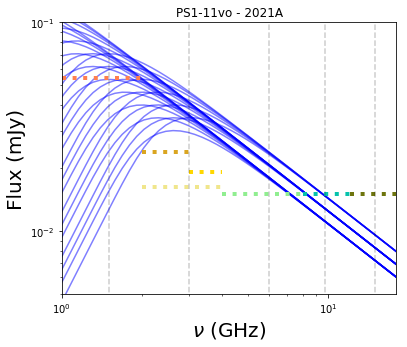

In [58]:
# Make a plot of the results for PS1-11vo:

t_p = 3311
D = 543.4

file_in = 'Projection_11vo_SSA_d3311.csv'
data_plot = ascii.read(file_in)

Fcalc = data_plot['F_peak']
nucalc = data_plot['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

#########################
#Set up the plot:
#########################
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(6,5))
plt.autoscale()
plt.xscale('log')
plt.yscale('log')


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)
    
#Overplot line for detection threshold:
plt.plot([1,2],[0.054, 0.054],linestyle=':',linewidth=4,color='coral')
#plt.plot([2,4],[0.018, 0.018],linestyle=':',linewidth=4)
#plt.plot([2,3],[0.027, 0.027],linestyle=':',linewidth=4)
#plt.plot([3,4],[0.0213, 0.0213],linestyle=':',linewidth=4)
plt.plot([2,4],[0.0162, 0.0162],linestyle=':',linewidth=4,color='khaki')
plt.plot([2,3],[0.024, 0.024],linestyle=':',linewidth=4,color='goldenrod')
plt.plot([3,4],[0.0192, 0.0192],linestyle=':',linewidth=4,color='gold')
plt.plot([4,8],[0.015, 0.015],linestyle=':',linewidth=4,color='lightgreen')
plt.plot([8,12],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:turquoise')
plt.plot([12,18],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:olive')



#Overplot central wavelengths for various bands:
plt.plot([15,15],[1e-3,1],'k--',alpha=0.2)
plt.plot([9.7,9.7],[1e-3,1],'k--',alpha=0.2)
plt.plot([6.0,6.0],[1e-3,1],'k--',alpha=0.2)
plt.plot([3.0,3.0],[1e-3,1],'k--',alpha=0.2)
plt.plot([1.5,1.5],[1e-3,1],'k--',alpha=0.2)


plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) 
plt.savefig('multiPS11aop.pdf')
plt.title('PS1-11vo - 2021A')   
plt.ylim(5e-3,1e-1)
plt.xlim(1,18)
plt.show()
